## Building Footprint Data
Loading bounding coordinates of buildings in the area.

Many studies suggest that the density of buildings in a
city influences ground temperatures and ultimately
contribute to the UHI issue. [Reference 3] This effect is
typically driven by buildings blocking the flow of air and
adding waste heat. For this challenge, we have
provided a building footprint dataset. Such information
could be used in your digital model as a feature that
drives local urban heating. 

In [1]:
import pandas as pd
import xml.etree.ElementTree as ET

def read_kml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    
    data = []
    for placemark in root.findall('.//kml:Placemark', ns):
        building = {}
        
        # Get all SimpleData fields
        for simple_data in placemark.findall('.//kml:SimpleData', ns):
            name = simple_data.get('name')
            value = simple_data.text
            building[name] = value
            
        # Get coordinates
        coords_elem = placemark.find('.//kml:coordinates', ns)
        if coords_elem is not None:
            coords_text = coords_elem.text.strip()
            # Store raw coordinates string
            building['coordinates'] = coords_text
            
            # Calculate centroid (average of all coordinates)
            coords = []
            for coord in coords_text.split():
                lon, lat = map(float, coord.split(',')[:2])
                coords.append((lon, lat))
            
            # Add centroid as separate columns
            if coords:
                building['longitude'] = sum(c[0] for c in coords) / len(coords)
                building['latitude'] = sum(c[1] for c in coords) / len(coords)
        
        data.append(building)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Convert numeric columns
    numeric_columns = ['fid', 'tessellate', 'extrude', 'visibility']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='ignore')
            
    return df

# Example usage
kml_file = "../data/Building_Footprint.kml"  # Make sure this path is correct
buildings_df = read_kml(kml_file)

/var/folders/fg/gtyh9bm95ssfs2_k2xlfk2d80000gp/T/ipykernel_36562/409316873.py:47: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Location Identifiers:

* id: Unique identifier (e.g., "cugir009034.3") for each building footprint
* fid: A numeric ID (like 7624, 7625, etc.)
* layer: Always "clip_Bronx" in this dataset, indicating these are buildings in the Bronx area
* path: The original file path where this data was processed from


Geometric Properties:

* coordinates: Raw string of longitude/latitude pairs that define the building's polygon outline
* longitude: Calculated center point (centroid) longitude of the building
* latitude: Calculated center point (centroid) latitude of the building


Rendering Properties:

* tessellate (-1): Controls whether the geometry should follow the terrain
* extrude (0): Controls whether the geometry should be extended down to the ground
* visibility (-1): Controls whether the feature is initially visible

In [2]:
import xml.etree.ElementTree as ET
import folium

def parse_coordinates(coord_str):
    # Split coordinates into pairs and convert to float
    coords = []
    pairs = coord_str.strip().split(' ')
    for pair in pairs:
        if pair:
            lon, lat = pair.split(',')[:2]  # Take only first two values
            coords.append([float(lat), float(lon)])  # Folium uses [lat, lon]
    return coords

def read_and_plot_kml(file_path):
    # Parse KML
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    # Create map centered on approximate middle of NYC
    m = folium.Map(location=[40.785, -73.95], zoom_start=13)
    
    # Define namespace
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}
    
    # Find all coordinate sets
    for coords in root.findall('.//kml:coordinates', ns):
        coord_list = parse_coordinates(coords.text)
        if coord_list:
            # Create polygon for each building
            folium.Polygon(
                locations=coord_list,
                color='blue',
                fill=True,
                weight=1
            ).add_to(m)
    
    # Save map
    m.save('../data/building_footprint.html')

# Use the function
kml_file = "../data/Building_Footprint.kml"  # Adjust path as needed
read_and_plot_kml(kml_file)

In [3]:
buildings_df = buildings_df.drop(columns=['tessellate', 'extrude', 'visibility', 'fid', 'layer', 'path'])

In [4]:
buildings_df.set_index('id', inplace=True)

In [5]:
display(buildings_df)

,coordinates,longitude,latitude
id,,,
cugir009034.3,"-73.919029,40.848199 -73.919329,40.847953 -73....",-73.919271,40.848072
cugir009034.4,"-73.921952,40.849629 -73.921911,40.849679 -73....",-73.921877,40.849621
cugir009034.5,"-73.920502,40.850113 -73.920453,40.850167 -73....",-73.920406,40.850095
cugir009034.6,"-73.92056,40.851403 -73.920531,40.851445 -73.9...",-73.920484,40.851394
cugir009034.142,"-73.912343,40.852184 -73.912472,40.852098 -73....",-73.912441,40.852190
...,...,...,...
cugir009062.5858,"-73.952668,40.779232 -73.95254,40.779428 -73.9...",-73.952174,40.779252
cugir009062.5859,"-73.949638,40.776133 -73.949312,40.776674 -73....",-73.948417,40.776069
cugir009062.5860,"-73.952102,40.768802 -73.951738,40.769309 -73....",-73.950884,40.768621


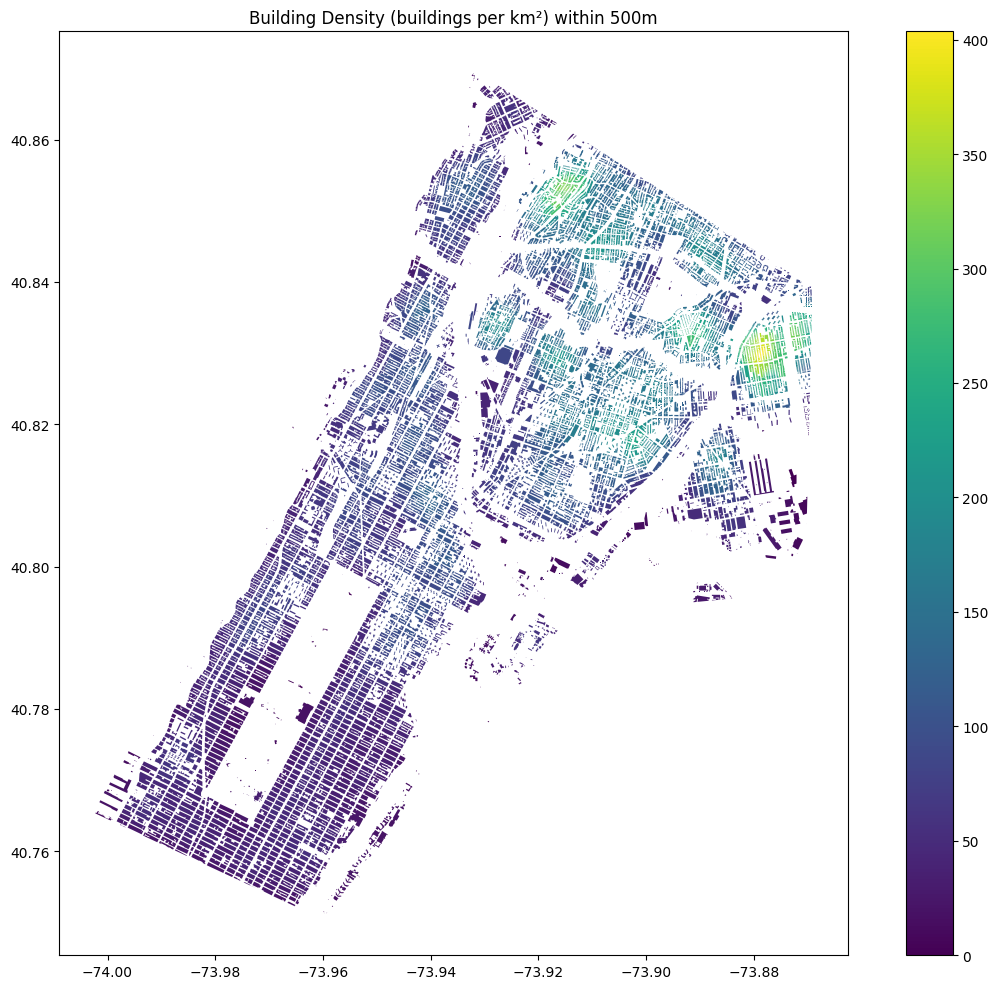

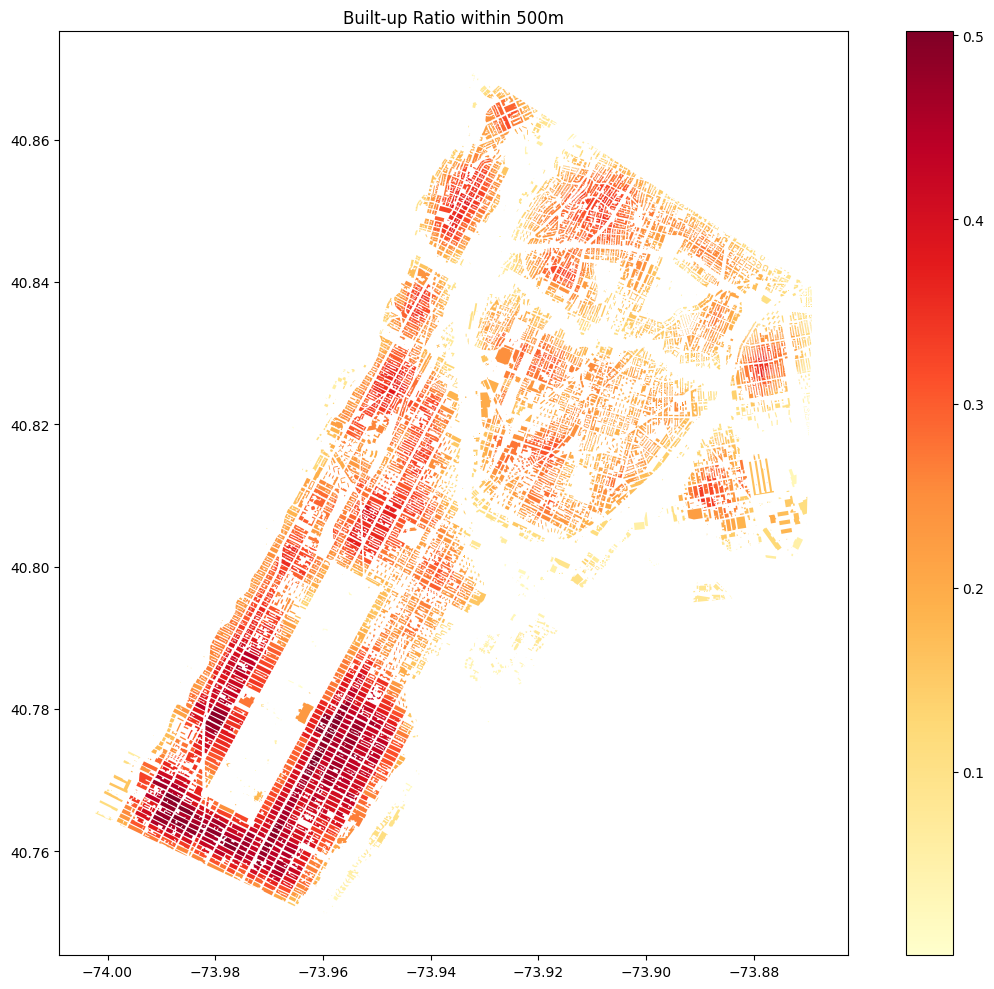

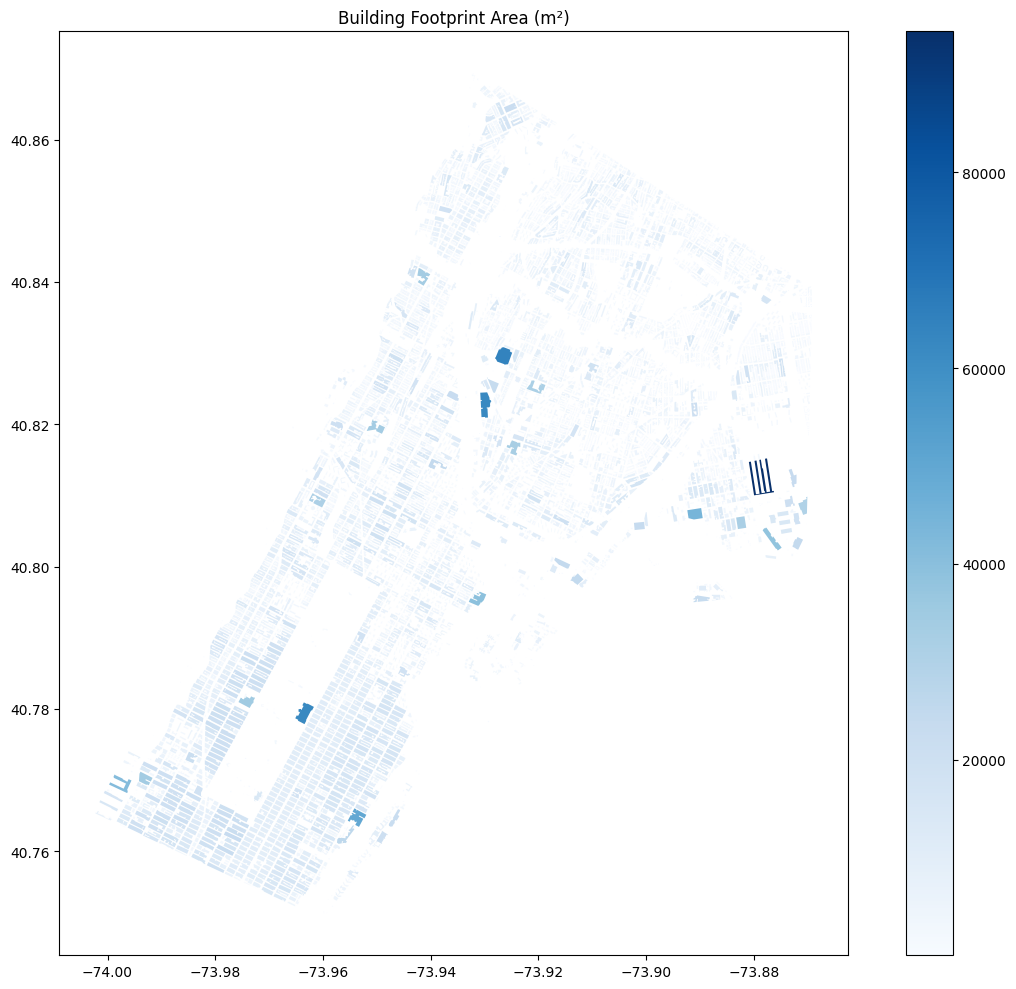

In [8]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

def parse_coordinates(coord_str):
    """
    Convert the raw coordinates string to a list of (lon, lat) tuples
    Handles various formats including space-separated coordinate pairs
    """
    if not isinstance(coord_str, str):
        return []
        
    # Clean the string and handle various formats
    coord_str = coord_str.strip()
    
    # Try to detect the format based on the given example:
    # "-73.919029,40.848199 -73.919329,40.847953 -73...."
    if ' ' in coord_str and ',' in coord_str:
        # Format is likely "lon,lat lon,lat ..."
        pairs = coord_str.split()
        coordinates = []
        
        for pair in pairs:
            try:
                if ',' in pair:
                    lon, lat = pair.split(',', 1)
                    coordinates.append((float(lon), float(lat)))
            except (ValueError, IndexError):
                continue
                
        return coordinates
        
    # Fallback to the original method
    # Remove brackets and split by comma
    pairs = coord_str.replace('[', '').replace(']', '').split(',')
    
    # Group into lon/lat pairs
    coordinates = []
    for i in range(0, len(pairs), 2):
        if i+1 < len(pairs):  # Ensure we have both lon and lat
            try:
                lon = float(pairs[i])
                lat = float(pairs[i+1])
                coordinates.append((lon, lat))
            except ValueError:
                continue  # Skip invalid coordinates
    
    return coordinates

def calculate_building_features(df):
    """
    Calculate UHI-relevant features for each building and surrounding area
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing building footprint data with columns:
        id, coordinates, longitude, latitude
    
    Returns:
    --------
    gdf : GeoDataFrame
        GeoDataFrame with original data plus added UHI-relevant features
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Parse coordinates and create geometry objects
    geometries = []
    areas = []
    perimeters = []
    
    for idx, row in df_copy.iterrows():
        try:
            coords = parse_coordinates(row['coordinates'])
            if len(coords) >= 3:  # Need at least 3 points for a polygon
                poly = Polygon(coords)
                geometries.append(poly)
                
                # Calculate area (m²)
                areas.append(poly.area * 111320**2)  # Rough conversion from degrees to meters
                
                # Calculate perimeter (m)
                perimeters.append(poly.length * 111320)  # Rough conversion from degrees to meters
            else:
                # Invalid polygon, use centroid as a Point instead
                geometries.append(Point(row['longitude'], row['latitude']))
                areas.append(0)
                perimeters.append(0)
        except (ValueError, TypeError):
            # Fallback to centroid if coordinates parsing fails
            geometries.append(Point(row['longitude'], row['latitude']))
            areas.append(0)
            perimeters.append(0)
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df_copy, geometry=geometries, crs="EPSG:4326")
    
    # Add building physical properties
    gdf['building_area_m2'] = areas
    gdf['building_perimeter_m'] = perimeters
    
    # Calculate building shape metrics (without height assumptions)
    # Compactness - ratio of area to perimeter (circular shapes have higher values)
    valid_perimeter = gdf['building_perimeter_m'] > 0
    gdf.loc[valid_perimeter, 'compactness'] = 4 * np.pi * gdf.loc[valid_perimeter, 'building_area_m2'] / (gdf.loc[valid_perimeter, 'building_perimeter_m']**2)
    gdf.loc[~valid_perimeter, 'compactness'] = np.nan
    
    # Calculate bounding box dimensions and aspect ratio
    def get_bbox_dimensions(geom):
        """Get width and length of the bounding box"""
        if hasattr(geom, 'bounds'):
            minx, miny, maxx, maxy = geom.bounds
            width = maxx - minx
            length = maxy - miny
            return width, length
        return np.nan, np.nan
        
    # Calculate for polygons only
    gdf['bbox_width'] = np.nan
    gdf['bbox_length'] = np.nan
    
    # Only process for Polygon geometries
    polygon_mask = gdf.geometry.type == 'Polygon'
    
    # Apply dimension calculation only to polygons
    for idx, geom in zip(gdf[polygon_mask].index, gdf[polygon_mask].geometry):
        width, length = get_bbox_dimensions(geom)
        gdf.at[idx, 'bbox_width'] = width
        gdf.at[idx, 'bbox_length'] = length
    
    # Calculate aspect ratio (length/width)
    valid_dimensions = (gdf['bbox_width'] > 0) & (gdf['bbox_length'] > 0)
    gdf.loc[valid_dimensions, 'aspect_ratio'] = gdf.loc[valid_dimensions, 'bbox_length'] / gdf.loc[valid_dimensions, 'bbox_width']
    gdf.loc[~valid_dimensions, 'aspect_ratio'] = np.nan
    
    # Simplified orientation calculation based on bounding box
    # This is a proxy for building orientation based on the longest dimension
    gdf['orientation'] = np.nan
    
    # Only calculate orientation for polygons where aspect ratio > 1.2 (non-square buildings)
    orientation_mask = (polygon_mask) & (gdf['aspect_ratio'] > 1.2)
    # Use 90° for buildings with length > width, and 0° otherwise
    # This is a simplified approach - 0° means aligned E-W, 90° means aligned N-S
    gdf.loc[orientation_mask & (gdf['bbox_length'] > gdf['bbox_width']), 'orientation'] = 90
    gdf.loc[orientation_mask & (gdf['bbox_length'] <= gdf['bbox_width']), 'orientation'] = 0
    
    # Complexity - ratio of the actual perimeter to the perimeter of a circle with the same area
    # Only calculate for valid polygons with non-zero area and perimeter
    valid_area = gdf['building_area_m2'] > 0
    valid_mask = valid_area & valid_perimeter
    
    # Initialize complexity column with NaN
    gdf['complexity'] = np.nan
    
    # Calculate complexity only for valid geometries
    if valid_mask.any():
        # Calculate denominator first to avoid division issues
        denominator = 2 * np.sqrt(np.pi * gdf.loc[valid_mask, 'building_area_m2'])
        # Only calculate for rows with valid denominator
        valid_denom = denominator > 0
        if valid_denom.any():
            valid_indices = gdf.loc[valid_mask].index[valid_denom]
            gdf.loc[valid_indices, 'complexity'] = gdf.loc[valid_indices, 'building_perimeter_m'] / denominator[valid_denom]
    
    return gdf

def calculate_density_metrics(gdf, radius_m=100):
    """
    Calculate density-based metrics for UHI analysis within a specific radius
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with building footprints and properties
    radius_m : float
        Radius in meters to calculate density features
    
    Returns:
    --------
    gdf : GeoDataFrame
        Original GeoDataFrame with added density metrics
    """
    radius_suffix = f"{int(radius_m)}m"
    
    # Convert to projected CRS for accurate distance calculations (UTM zone depends on location)
    gdf_proj = gdf.to_crs(epsg=3857)  # Web Mercator projection
    
    # Create a BallTree for efficient nearest neighbor search
    coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf_proj.geometry])
    tree = BallTree(coords, metric='euclidean')
    
    # Find neighbors within radius
    indices = tree.query_radius(coords, r=radius_m)
    
    # Calculate density metrics
    building_count = []
    building_density = []
    floor_area_ratio = []
    built_up_ratio = []
    
    for i, idx_array in enumerate(indices):
        # Area of the circle
        circle_area = np.pi * radius_m**2
        
        # Count of buildings in radius (excluding self)
        count = len(idx_array) - 1
        building_count.append(count)
        
        # Building density (buildings per square km)
        density = count / (circle_area / 1000000)
        building_density.append(density)
        
        # Floor area ratio (total building area / land area)
        # Without height data, this is a 2D footprint coverage ratio
        total_building_area = gdf_proj.iloc[idx_array]['building_area_m2'].sum()
        far = total_building_area / circle_area
        floor_area_ratio.append(far)
        
        # Built-up ratio - different from FAR as it considers the actual geometric coverage
        # by calculating the union of building footprints
        if len(idx_array) > 0:
            # Use the sum of building areas as a simpler approximation
            # This avoids potential issues with geometric operations
            nearby_building_areas = gdf_proj.iloc[idx_array]['building_area_m2'].sum()
            
            # Area of the circle
            neighborhood_area = np.pi * radius_m**2
            
            # Calculate the ratio (this is actually the same as FAR in this case)
            # But we're using a different name to distinguish conceptually
            built_up_ratio.append(nearby_building_areas / neighborhood_area)
        else:
            built_up_ratio.append(0)
    
    # Add metrics to the original GeoDataFrame with radius suffix
    gdf[f'nearby_building_count_{radius_suffix}'] = building_count
    gdf[f'building_density_per_km2_{radius_suffix}'] = building_density
    gdf[f'footprint_coverage_ratio_{radius_suffix}'] = floor_area_ratio
    gdf[f'built_up_ratio_{radius_suffix}'] = built_up_ratio
    
    # Calculate impervious surface ratio (approximation without actual land cover data)
    # Assuming buildings typically have associated impervious surfaces around them
    # This is a coefficient that could be adjusted based on local urban typology
    impervious_coefficient = 1.5  # Buildings typically have 1.5x their footprint as impervious area
    gdf[f'estimated_impervious_ratio_{radius_suffix}'] = np.minimum(
        gdf[f'built_up_ratio_{radius_suffix}'] * impervious_coefficient, 
        1.0  # Cap at 1.0 (100%)
    )
    
    # Calculate indicators of urban canyon formation
    # Without height, we use building density and proximity as proxy indicators
    gdf[f'canyon_formation_potential_{radius_suffix}'] = (
        gdf[f'building_density_per_km2_{radius_suffix}'] / gdf[f'building_density_per_km2_{radius_suffix}'].max() * 
        gdf[f'built_up_ratio_{radius_suffix}']
    )
    
    return gdf

def prepare_features_for_modeling(gdf):
    """
    Prepare standardized features from building footprint data for UHI modeling
    without introducing biased pre-calculated indices
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame with building footprint data and calculated metrics
    
    Returns:
    --------
    gdf : GeoDataFrame
        Original GeoDataFrame with standardized features suitable for modeling
    """
    # Find radius suffixes in column names
    radius_suffixes = []
    for col in gdf.columns:
        if 'built_up_ratio_' in col:
            suffix = col.split('built_up_ratio_')[1]
            radius_suffixes.append(suffix)
    
    # If no density calculations were done, return the dataframe as is
    if not radius_suffixes:
        return gdf
    
    # Standardize relevant numeric features
    # This is different from normalization - it centers data around mean with unit variance
    # This approach is more suitable for modeling than the previous 0-1 normalization
    numeric_features = [
        'building_area_m2',
        'building_perimeter_m',
        'compactness',
        'aspect_ratio',
        'complexity'
    ]
    
    # Add radius-specific features
    for suffix in radius_suffixes:
        radius_features = [
            f'nearby_building_count_{suffix}',
            f'building_density_per_km2_{suffix}',
            f'footprint_coverage_ratio_{suffix}',
            f'built_up_ratio_{suffix}',
            f'estimated_impervious_ratio_{suffix}',
            f'canyon_formation_potential_{suffix}'
        ]
        numeric_features.extend(radius_features)
    
    # Standardize each numeric feature individually
    # (value - mean) / std to get z-scores
    # This creates features with mean=0 and std=1, suitable for most ML models
    for feature in numeric_features:
        if feature in gdf.columns:
            # Skip features with all zeros or NaN
            if gdf[feature].isna().all() or (gdf[feature] == 0).all():
                continue
                
            # Get non-NaN values
            valid_values = gdf[feature].dropna()
            if len(valid_values) == 0:
                continue
                
            # Calculate mean and std from valid values
            feature_mean = valid_values.mean()
            feature_std = valid_values.std()
            
            # Skip if std is zero (constant feature)
            if feature_std == 0:
                continue
                
            # Create standardized feature
            std_feature_name = f'{feature}_std'
            gdf[std_feature_name] = (gdf[feature] - feature_mean) / feature_std
    
    return gdf

def analyze_building_footprints_for_uhi(df, output_file=None, plot=False):
    """
    Main function to extract UHI-relevant features from building footprints
    without assuming building heights or creating biased indices
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing building footprint data with columns:
        id, coordinates, longitude, latitude
    output_file : str, optional
        Path to save the output GeoDataFrame as a GeoJSON file
    plot : bool, default=False
        Whether to generate and show plots of the results
    
    Returns:
    --------
    gdf : GeoDataFrame
        GeoDataFrame with all calculated UHI-relevant features
    """
    # Calculate basic building features
    gdf = calculate_building_features(df)
    
    # Calculate density-based metrics (100m and 500m radii)
    gdf = calculate_density_metrics(gdf, radius_m=100)
    gdf = calculate_density_metrics(gdf, radius_m=500)
    
    # Prepare features for modeling (standardize without creating biased indices)
    gdf = prepare_features_for_modeling(gdf)
    
    # Save to file if specified
    if output_file:
        gdf.to_file(output_file, driver='GeoJSON')
    
    # Generate plots if requested
    if plot:
        # Plot building density
        fig, ax = plt.subplots(figsize=(12, 10))
        gdf.plot(column='building_density_per_km2_500m', cmap='viridis', linewidth=0.1, ax=ax, legend=True)
        ax.set_title('Building Density (buildings per km²) within 500m')
        plt.tight_layout()
        plt.show()
        
        # Plot built-up ratio
        fig, ax = plt.subplots(figsize=(12, 10))
        gdf.plot(column='built_up_ratio_500m', cmap='YlOrRd', linewidth=0.1, ax=ax, legend=True)
        ax.set_title('Built-up Ratio within 500m')
        plt.tight_layout()
        plt.show()
        
        # Plot building size
        fig, ax = plt.subplots(figsize=(12, 10))
        gdf.plot(column='building_area_m2', cmap='Blues', linewidth=0.1, ax=ax, legend=True)
        ax.set_title('Building Footprint Area (m²)')
        plt.tight_layout()
        plt.show()
    
    return gdf

# Example usage:
result_gdf = analyze_building_footprints_for_uhi(buildings_df, output_file='uhi_analysis.geojson', plot=True)

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree

def spatial_join_uhi_features(buildings_gdf, inference_df, max_distance=500):
    """
    Efficiently join UHI features to inference points using spatial relationships
    
    Parameters:
    -----------
    buildings_gdf : GeoDataFrame
        GeoDataFrame containing building footprints with UHI features
    inference_df : DataFrame
        DataFrame containing points for inference with columns 'longitude' and 'latitude'
    max_distance : float, default=500
        Maximum distance in meters to consider for nearest neighbor matching
        
    Returns:
    --------
    result_df : DataFrame
        Original inference DataFrame with added UHI features
    """
    print(f"Starting spatial join with {len(buildings_gdf)} buildings and {len(inference_df)} inference points")
    
    # Create a copy of the inference DataFrame
    result_df = inference_df.copy()
    
    # Convert inference points to GeoDataFrame
    inference_gdf = gpd.GeoDataFrame(
        inference_df, 
        geometry=[Point(xy) for xy in zip(inference_df['Longitude'], inference_df['Latitude'])],
        crs=buildings_gdf.crs
    )
    
    # Method 1: For points that fall WITHIN building polygons
    print("Finding points within building polygons...")
    
    # Only use polygons for the spatial join, not points
    polygon_buildings = buildings_gdf[buildings_gdf.geometry.type == 'Polygon'].copy()
    
    if len(polygon_buildings) > 0:
        # Spatial join - points that fall within polygons
        joined = gpd.sjoin(inference_gdf, polygon_buildings, how='left', predicate='within')
        
        # Get indices of points that were successfully joined
        joined_indices = joined.index[~joined['index_right'].isna()].tolist()
        print(f"Found {len(joined_indices)} points inside building polygons")
        
        # For points inside polygons, copy all UHI features
        for col in buildings_gdf.columns:
            if col != 'geometry' and col in joined.columns:
                result_df.loc[joined_indices, col] = joined.loc[joined_indices, col]
    else:
        joined_indices = []
        print("No polygon geometries found in buildings data")
    
    # Method 2: For remaining points, use KD-Tree to find nearest building
    unmatched_indices = list(set(inference_gdf.index) - set(joined_indices))
    print(f"Finding nearest buildings for {len(unmatched_indices)} remaining points...")
    
    if len(unmatched_indices) > 0:
        # Extract coordinates from both datasets for KDTree
        buildings_coords = np.array([(geom.centroid.x, geom.centroid.y) 
                                     for geom in buildings_gdf.geometry])
        
        inference_coords = np.array([(geom.x, geom.y) 
                                     for geom in inference_gdf.loc[unmatched_indices, 'geometry']])
        
        # Build KD-Tree for efficient nearest neighbor search
        tree = cKDTree(buildings_coords)
        
        # Find nearest neighbor for each unmatched point
        distances, indices = tree.query(inference_coords, k=1)
        
        # Convert distances from degrees to approximate meters
        # This is a rough conversion that works reasonably well for small distances
        distances_meters = distances * 111320  # 1 degree ~ 111.32 km at the equator
        
        # Only use neighbors within max_distance
        valid_neighbors = distances_meters < max_distance
        valid_indices = np.array(unmatched_indices)[valid_neighbors]
        valid_building_indices = indices[valid_neighbors]
        
        print(f"Found {len(valid_indices)} points with buildings within {max_distance}m")
        
        # Copy features from nearest buildings to result DataFrame
        for i, idx in enumerate(valid_indices):
            building_idx = valid_building_indices[i]
            for col in buildings_gdf.columns:
                if col != 'geometry':
                    result_df.loc[idx, col] = buildings_gdf.iloc[building_idx][col]
        
        # For points with no buildings within max_distance,
        # use distance-weighted interpolation from multiple nearby buildings
        remaining_indices = list(set(unmatched_indices) - set(valid_indices))
        
        if len(remaining_indices) > 0:
            print(f"Interpolating features for {len(remaining_indices)} distant points...")
            
            # For each remaining point, find k nearest buildings and calculate
            # distance-weighted averages of UHI features
            k = min(5, len(buildings_gdf))  # Use up to 5 nearest buildings
            remaining_coords = np.array([(geom.x, geom.y) 
                                        for geom in inference_gdf.loc[remaining_indices, 'geometry']])
            
            distances_k, indices_k = tree.query(remaining_coords, k=k)
            
            # Iterate through each remaining point
            for i, idx in enumerate(remaining_indices):
                # Get weights based on inverse distance
                weights = 1.0 / (distances_k[i] + 1e-10)  # Add small epsilon to avoid division by zero
                weights = weights / np.sum(weights)  # Normalize weights
                
                # Calculate weighted average for each feature
                for col in buildings_gdf.columns:
                    if col != 'geometry' and buildings_gdf[col].dtype in [np.float64, np.int64]:
                        # Only interpolate numeric columns
                        values = buildings_gdf.iloc[indices_k[i]][col].values
                        result_df.loc[idx, col] = np.sum(values * weights)
    
    # Convert any object dtypes back to appropriate numeric types
    for col in result_df.columns:
        if result_df[col].dtype == 'object' and col in buildings_gdf.columns:
            try:
                if buildings_gdf[col].dtype == np.float64:
                    result_df[col] = result_df[col].astype(float)
                elif buildings_gdf[col].dtype == np.int64:
                    result_df[col] = result_df[col].astype(int)
            except:
                pass
    
    print(f"Spatial join complete. Result has {len(result_df)} rows with UHI features")
    return result_df

# Example usage:
# inference_df = pd.read_csv('inference_points.csv')  # Should have 'Longitude' and 'Latitude' columns
# result_df = spatial_join_uhi_features(buildings_gdf, inference_df, max_distance=500)